In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook 

'''
    Нахождение скорости в м/мин. Принимает расход в бар/сут и диаметр в in
Внешний диаметр SNL 9 - 42 мм
'''

def velocity(Q, ID):
    ID = 0.0254*ID # Перевод в метры
    Q = 0.158987*Q    # Перевод в м^3/сут
    
    return Q/(3.14*(ID/2)**2)/(24*60)

velocity(6000, 3.95) ### м/мин

'''
    Нахождение скорости, с учётом размера прибора, в м/мин. Принимает расход в бар/сут и диаметр в in
Внешний диаметр SNL 9 - 42 мм
'''

def velocity_ring(Q, ID):
    ID = 0.0254*ID # Перевод в метры
    Q = 0.158987*Q    # Перевод в м^3/сут
    
    return Q/(3.14*((ID/2)**2-(0.042/2)**2))/(24*60)


# 1 - water, 2 - oil, 3 - gas

'''
    Функция retunr_I принимает в аргументы расход Q (m3/d), внутренний диаметр трубы Din (mm) 
и тип флюида: 1 - water, 2 - oil, 3 - gas.
Возвращает значение интенсивности по Лайтхиллу

'''
def return_I(Q, Din, type):
    Q = Q/24/3600
    # Q=[27 33 39 47 59 67]/24/3600;
    # 1BPD = 0.16 m3/d

    Din = Din*10**(-3) # in mm

    Dsnl = 42*10**(-3)
    d = (Din-Dsnl)/2
    rho_all = [1000, 780, 1.977]
    mu_all = [0.4*10**(-3), 10*10**(-3), 15*10**(-6)]
    c0_all = [1510, 1290, 430]

    rho=rho_all[type-1]
    mu=mu_all[type-1]
    c0=c0_all[type-1]

    Sin=3.1416*(Din/2)**2
    Ssnl=3.1416*(Dsnl/2)**2

    U=Q/(Sin-Ssnl)

    Re=rho*U*d/mu
    I=(rho*U**8*d**2)/(c0**5)*10**6

    result=[U, Re/1000, I*(10**18)]
    
    return I 


'''
    Функция recovery_Q принимает в аргументы критическую интенсивность по Лайтхиллу (Icr) 
и тип флюида: 1 - water, 2 - oil, 3 - gas.
Возвращает сгенерированный набор значений Q[bpd] и набор внутренних диаметров D[inc]

'''

def recovery_Q(Icr, type):
    Din_inc = [2.441, 2.259, 2.992, 2.750, 3.548, 3.476, 3.958, 3.5, 4.408, 4.044, 4.778,
           4.276, 6.366, 5.92, 5.54, 8.835, 8.435, 10.772, 10.5, 12.347, 12.125, 11.907]
    Din_inc.sort()
    Din = np.array(Din_inc)*25.4*10**(-3)
    Dsnl = 40*10**(-3)

    d = (Din-Dsnl)/2

    rho_all=[1000, 780, 150]
    mu_all=[0.4*10**(-3), 10*10**(-3), 0.02*10**(-3)]
    c0_all=[1510, 1290, 430]

    rho=rho_all[type-1]
    mu=mu_all[type-1]
    c0=c0_all[type-1]

    Sin = 3.1416*(Din/2)**2
    Ssnl = 3.1416*(Dsnl/2)**2

    Ucr = (Icr*c0**5/(10**6*rho*d**2))**(1/8)
    Qcr = np.round(Ucr*(Sin-Ssnl)*24*3600/0.16)
    Qcr_m3 = np.round(Ucr*(Sin-Ssnl)*24*3600)
    
    return Qcr, Din_inc

excel_data = pd.read_excel('TGT_wells.xlsx',  sheet_name='Лист1')
excel_data

,№,Well,Type of well,Type of fluid,OD,ID,Tool,Chorus QC (LFP/HFP),"Max flow rates, BPD",LFP,HFP
0,39.0,Almetyevsk,Flow loop,Water,NaN,3.950,10a,good/good,724.608,1,1
1,57.0,Almetyevsk,Flow loop,Water,NaN,3.950,9a,good/good,754.800,1,1
2,97.0,Almetyevsk(2021),Flow loop,Water,NaN,3.950,9a,good/good,754.800,1,1
3,102.0,Almetyevsk(2021),Flow loop,Water,NaN,3.950,9a,good/good,754.800,1,1
4,62.0,Almetyevsk,Flow loop,Water,NaN,3.950,9a,good/good,769.896,1,1
...,...,...,...,...,...,...,...,...,...,...,...
105,95.0,Almetyevsk(2021),Flow loop,Water,NaN,3.950,10a,normal/normal,29497.580,2,2
106,115.0,Almetyevsk(2021),Flow loop,Water,NaN,3.950,9a,normal/bad,29497.580,2,3
107,75.0,Almetyevsk,Flow loop,Water,NaN,3.950,9a,normal/bad,29497.600,2,3
108,30.0,DIAS-02,Water Injector,Water,4.500,3.950,9a,normal/bad,20630.580,2,3


## Chorus 9A

### Данные с реальных скважин

<IPython.core.display.Javascript object>


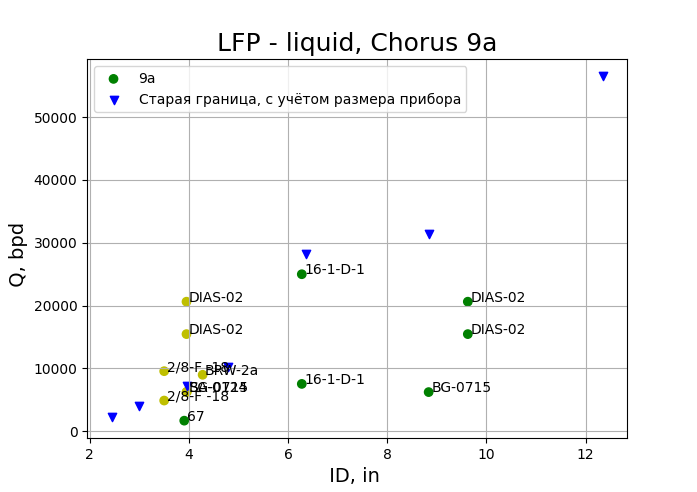

In [69]:
fig, ax = plt.subplots() 

chor = '9a'
freq = 'LFP'

data = excel_data.query(f"Tool == '{chor}' & Well != 'Almetyevsk(2021)' & Well != 'Almetyevsk'")

ID = data['ID']
Q = data['Max flow rates, BPD']
name =  data['Well']

c = np.array(data[f'{freq}'])
d = {1:'g', 2:'y', 3:'r'}

ID_old = [2.441, 2.992, 3.958, 4.778, 6.366, 8.835, 12.347] ## in
Q_old = [2300, 4000, 7200, 10300, 28200, 31400, 56500]  ## bpd

ax.scatter(ID, Q, c=[d[i] for i in c], marker='o')
ax.scatter(ID_old, Q_old, marker='v', color='b')

ax.legend([chor, 'Старая граница, с учётом размера прибора', 'Альметьевские эксперименты'])

plt.grid()
ax.set_ylabel(' Q, bpd   ',
              fontsize = 14,    #  размер шрифта
              color = 'black')     #  ширина крайней линии

ax.set_xlabel(' ID, in  ',
              fontsize = 14,
              color = 'black')
ax.set_title(f'{freq} - liquid, Chorus {chor}', fontsize=18)

for i in range(len(Q)):
    ax.annotate(f'{np.array(name)[i]}', xy=(np.array(ID)[i]+0.05, np.array(Q)[i]), fontsize=10)

<IPython.core.display.Javascript object>


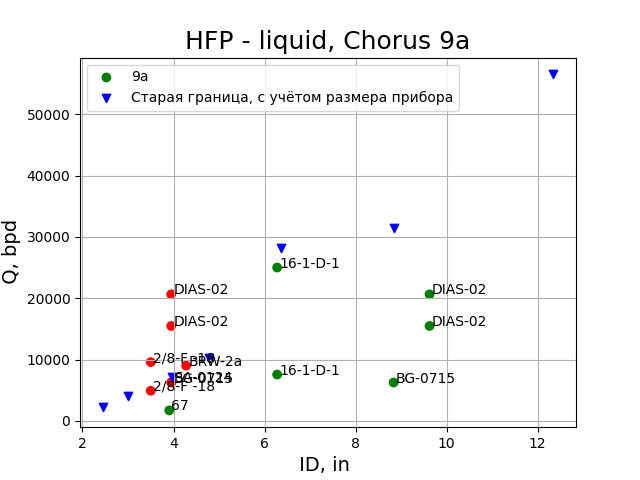

In [70]:
fig, ax = plt.subplots() 

chor = '9a'
freq = 'HFP'

data = excel_data.query(f"Tool == '{chor}' & Well != 'Almetyevsk(2021)' & Well != 'Almetyevsk'")

ID = data['ID']
Q = data['Max flow rates, BPD']
name =  data['Well']

c = np.array(data[f'{freq}'])
v = [velocity_ring(Q, OD) for Q, OD in zip(Q, ID)]
d = {1:'g', 2:'y', 3:'r'}

ID_old = [2.441, 2.992, 3.958, 4.778, 6.366, 8.835, 12.347] ## in
Q_old = [2300, 4000, 7200, 10300, 28200, 31400, 56500]  ## bpd
v_old = [velocity_ring(Q, ID) for Q, ID in zip(Q_old, ID_old)]

ax.scatter(ID, Q, c=[d[i] for i in c], marker='o')
ax.scatter(ID_old, Q_old, marker='v', color='b')

ax.legend([chor, 'Старая граница, с учётом размера прибора', 'Альметьевские эксперименты'])

plt.grid()
ax.set_ylabel(' Q, bpd    ',
              fontsize = 14,    #  размер шрифта
              color = 'black')     #  ширина крайней линии

ax.set_xlabel(' ID, in  ',
              fontsize = 14,
              color = 'black')
ax.set_title(f'{freq} - liquid, Chorus {chor}', fontsize=18)

for i in range(len(Q)):
    ax.annotate(f'{np.array(name)[i]}', xy=(np.array(ID)[i]+0.05, np.array(Q)[i]), fontsize=10)

## Расчёт интенсивностей по Лайтхиллу и нахождение критического значения

<IPython.core.display.Javascript object>


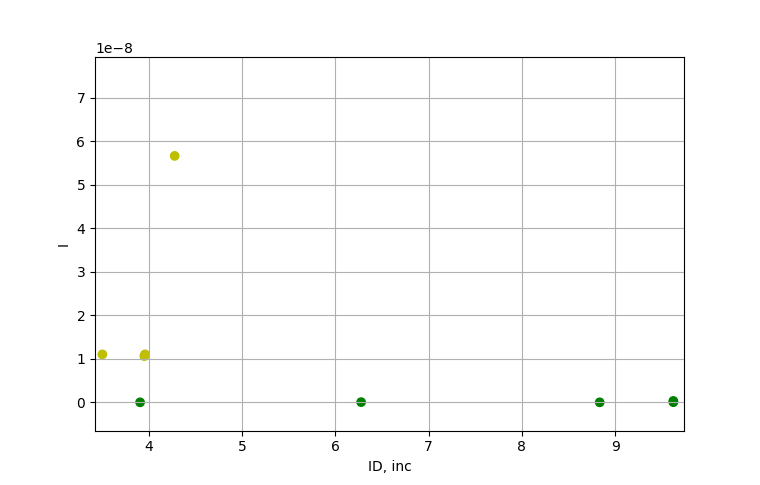

In [15]:
freq = 'LFP'

data = excel_data.query(f"Tool == '9a' & Well != 'Almetyevsk(2021)' & Well != 'Almetyevsk'")

ID = data['ID']
Q = data['Max flow rates, BPD']
name =  data['Well']

c = np.array(data[f'{freq}'])
grade = data['LFP']
grade = np.array(grade)
d = {1:'g', 2:'y', 3:'r'}

I_mass = [return_I(Q*0.16, D*25.4, type=1) for Q, D in zip(Q, ID)]

plt.scatter(ID, I_mass, c = [d[i] for i in grade])
plt.xlabel('ID, inc')
plt.ylabel('I')
plt.grid()

### Получили Icr порядка 0.5*10^(-8)
### Сгенерируем кривую по этому параметру 

<IPython.core.display.Javascript object>


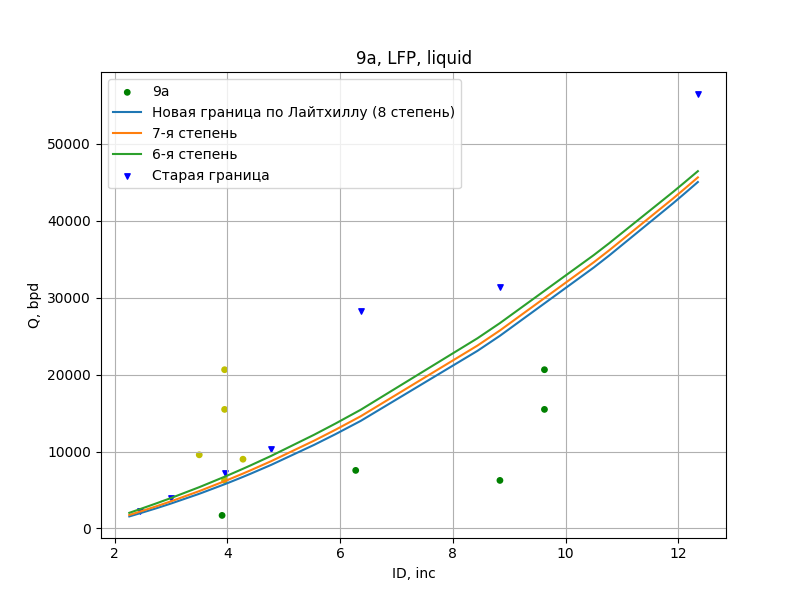

In [156]:
freq = 'LFP'

data = excel_data.query(f"Tool == '9a' & Well != 'Almetyevsk(2021)' & Well != 'Almetyevsk'")

ID = data['ID']
Q = data['Max flow rates, BPD']

c = np.array(data[f'{freq}'])
d = {1:'g', 2:'y', 3:'r'}

### Almet data
almet = excel_data.query(f"Tool == '9a' & (Well == 'Almetyevsk(2021)' or Well == 'Almetyevsk')")
ID_a = almet['ID']
Q_a = almet['Max flow rates, BPD']

c_a = np.array(almet[f'{freq}'])
### end

ID_old = [2.441, 2.992, 3.958, 4.778, 6.366, 8.835, 12.347] ## in
Q_old = [2300, 4000, 7200, 10300, 28200, 31400, 56500]  ## bpd

Q_Lite, Dinc = recovery_Q(0.5*10**(-8), type=1)

plt.scatter(ID, Q, c=[d[i] for i in c], s=15)

Qcr_8, Din_inc = recovery_Q_pow(0.5*10**(-8), type=1, power=8)
Qcr_7, _ = recovery_Q_pow(0.5*10**(-8), type=1, power=7)
Qcr_6, _ = recovery_Q_pow(0.5*10**(-8), type=1, power=6)

Qcr_8, Din_inc = recovery_Q_pow(0.5*10**(-8), type=1, power=8)
Qcr_7, _ = recovery_Q_pow(0.5*10**(-8), type=1, power=7)
Qcr_6, _ = recovery_Q_pow(0.5*10**(-8), type=1, power=6)

plt.plot(Din_inc, Qcr_8)
plt.plot(Din_inc, Qcr_7)
plt.plot(Din_inc, Qcr_6)

plt.scatter(ID_old, Q_old, c='b', marker='v', s=15)

#plt.fill_between(Dinc, Q_Lite, 0, facecolor='green', alpha = 0.2)
#plt.fill_between(Dinc, Q_Lite, max(Q_Lite), facecolor='yellow', alpha = 0.2)

plt.xlabel('ID, inc')
plt.ylabel('Q, bpd')
plt.title(f'9a, {freq}, liquid')
plt.legend(['9a', 'Новая граница по Лайтхиллу (8 степень)', '7-я степень', '6-я степень',
            'Старая граница'])
plt.grid()

# Chorus 10A

### Данные с реальных скважин

<IPython.core.display.Javascript object>


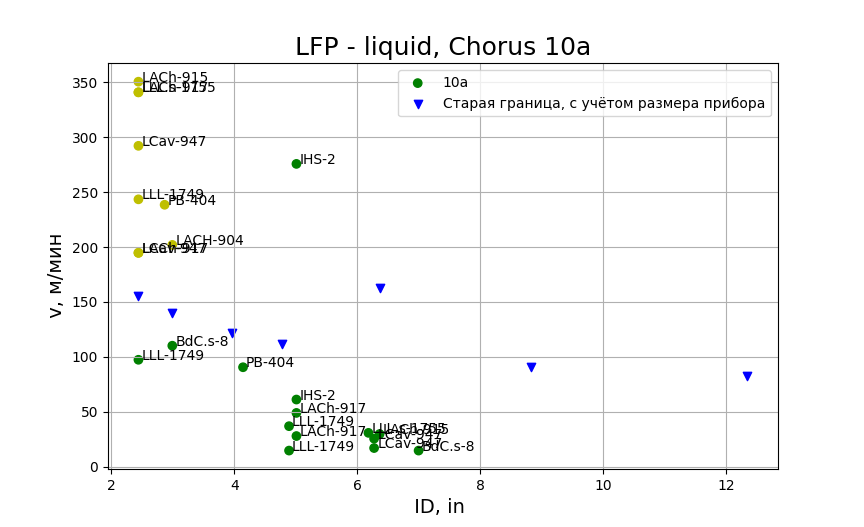

In [72]:
fig, ax = plt.subplots() 

chor = '10a'
freq = 'LFP'

data = excel_data.query(f"Tool == '{chor}' & Well != 'Almetyevsk(2021)' & Well != 'Almetyevsk'")

ID = data['ID']
Q = data['Max flow rates, BPD']
name =  data['Well']

c = np.array(data[f'{freq}'])
v = [velocity_ring(Q, OD) for Q, OD in zip(Q, ID)]
d = {1:'g', 2:'y', 3:'r'}

ID_old = [2.441, 2.992, 3.958, 4.778, 6.366, 8.835, 12.347] ## in
Q_old = [2300, 4000, 7200, 10300, 28200, 31400, 56500]  ## bpd
v_old = [velocity_ring(Q, ID) for Q, ID in zip(Q_old, ID_old)]

ax.scatter(ID, v, c=[d[i] for i in c], marker='o')
ax.scatter(ID_old, v_old, marker='v', color='b')

ax.legend([chor, 'Старая граница, с учётом размера прибора', 'Альметьевские эксперименты'])

plt.grid()
ax.set_ylabel(' v, м/мин    ',
              fontsize = 14,    #  размер шрифта
              color = 'black')     #  ширина крайней линии

ax.set_xlabel(' ID, in  ',
              fontsize = 14,
              color = 'black')
ax.set_title(f'{freq} - liquid, Chorus {chor}', fontsize=18)

for i in range(len(Q)):
    ax.annotate(f'{np.array(name)[i]}', xy=(np.array(ID)[i]+0.05, np.array(v)[i]), fontsize=10)

<IPython.core.display.Javascript object>


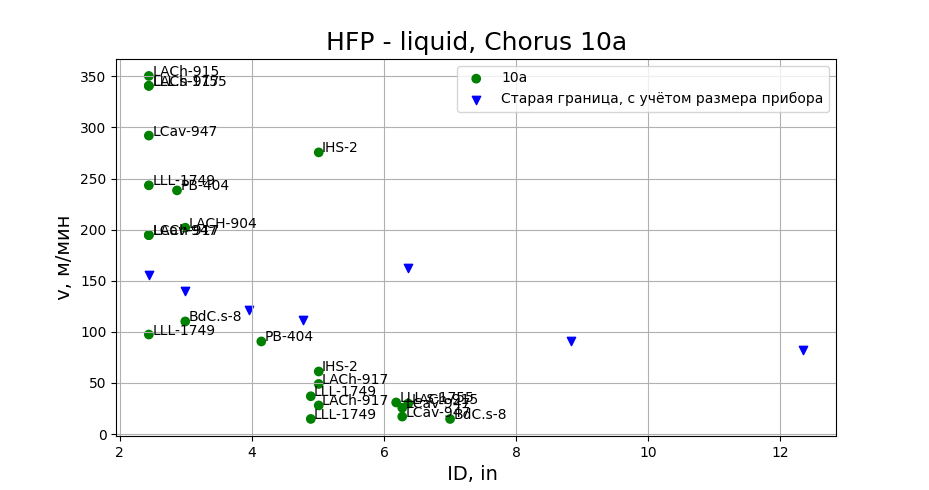

In [73]:
fig, ax = plt.subplots() 

chor = '10a'
freq = 'HFP'

data = excel_data.query(f"Tool == '{chor}' & Well != 'Almetyevsk(2021)' & Well != 'Almetyevsk'")

ID = data['ID']
Q = data['Max flow rates, BPD']
name =  data['Well']

c = np.array(data[f'{freq}'])
v = [velocity_ring(Q, OD) for Q, OD in zip(Q, ID)]
d = {1:'g', 2:'y', 3:'r'}

ID_old = [2.441, 2.992, 3.958, 4.778, 6.366, 8.835, 12.347] ## in
Q_old = [2300, 4000, 7200, 10300, 28200, 31400, 56500]  ## bpd
v_old = [velocity_ring(Q, ID) for Q, ID in zip(Q_old, ID_old)]

ax.scatter(ID, v, c=[d[i] for i in c], marker='o')
ax.scatter(ID_old, v_old, marker='v', color='b')

ax.legend([chor, 'Старая граница, с учётом размера прибора', 'Альметьевские эксперименты'])

plt.grid()
ax.set_ylabel(' v, м/мин    ',
              fontsize = 14,    #  размер шрифта
              color = 'black')     #  ширина крайней линии

ax.set_xlabel(' ID, in  ',
              fontsize = 14,
              color = 'black')
ax.set_title(f'{freq} - liquid, Chorus {chor}', fontsize=18)

for i in range(len(Q)):
    ax.annotate(f'{np.array(name)[i]}', xy=(np.array(ID)[i]+0.05, np.array(v)[i]), fontsize=10)

## Расчёт интенсивностей по Лайтхиллу и нахождение критического значения - 10a

<IPython.core.display.Javascript object>


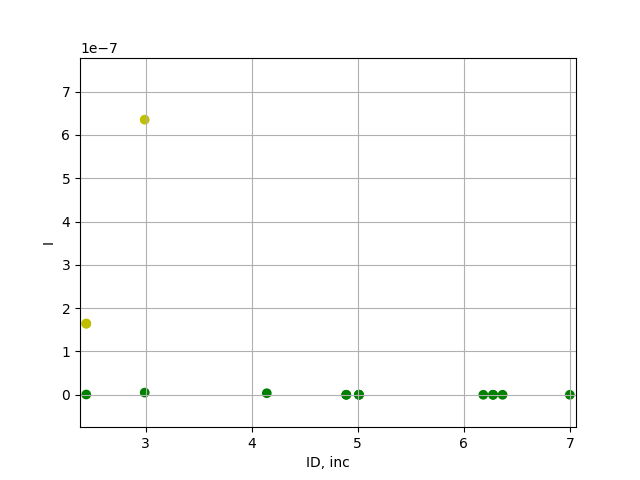

In [28]:
freq = 'LFP'

data = excel_data.query(f"Tool == '10a' & Well != 'Almetyevsk(2021)' & Well != 'Almetyevsk'")

ID = data['ID']
Q = data['Max flow rates, BPD']
name =  data['Well']

c = np.array(data[f'{freq}'])
grade = data['LFP']
grade = np.array(grade)
d = {1:'g', 2:'y', 3:'r'}

I_mass = [return_I(Q*0.16, D*25.4, type=1) for Q, D in zip(Q, ID)]

plt.scatter(ID, I_mass, c = [d[i] for i in grade])
plt.xlabel('ID, inc')
plt.ylabel('I')
plt.grid()

### Получили Icr порядка 0.5*10^(-7)
### Сгенерируем кривую по этому параметру 

<IPython.core.display.Javascript object>


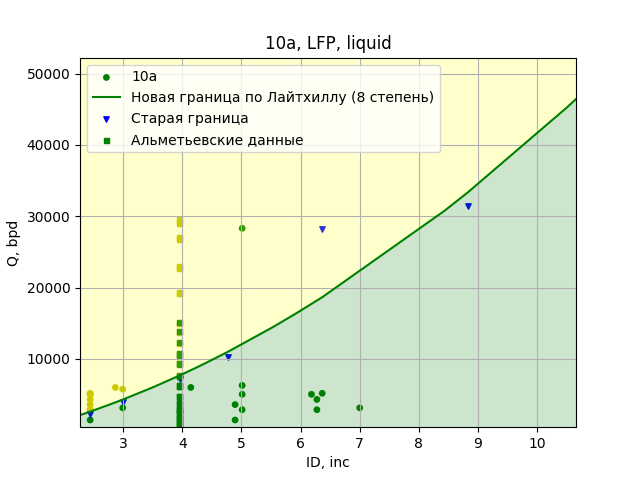

In [141]:
freq = 'LFP'

data = excel_data.query(f"Tool == '10a' & Well != 'Almetyevsk(2021)' & Well != 'Almetyevsk'")

### Almet data
almet = excel_data.query(f"Tool == '10a' & (Well == 'Almetyevsk(2021)' or Well == 'Almetyevsk')")
ID_a = almet['ID']
Q_a = almet['Max flow rates, BPD']

c_a = np.array(almet[f'{freq}'])
### end

ID = data['ID']
Q = data['Max flow rates, BPD']

c = np.array(data[f'{freq}'])
d = {1:'g', 2:'y', 3:'r'}

ID_old = [2.441, 2.992, 3.958, 4.778, 6.366, 8.835, 12.347] ## in
Q_old = [2300, 4000, 7200, 10300, 28200, 31400, 56500]  ## bpd

Q_Lite, Dinc = recovery_Q(0.5*10**(-7), type=1)

plt.scatter(ID, Q, c=[d[i] for i in c], s=15)
plt.plot(Dinc, Q_Lite, 'g')
plt.scatter(ID_old, Q_old, c='b', marker='v', s=15)
plt.scatter(ID_a, Q_a, c=[d[i] for i in c_a], marker='s', s = 15)
#plt.fill_between(Dinc, Q_Lite, 0, facecolor='green', alpha = 0.2)
#plt.fill_between(Dinc, Q_Lite, max(Q_Lite), facecolor='yellow', alpha = 0.2)

plt.xlabel('ID, inc')
plt.ylabel('Q, bpd')
plt.title(f'10a, {freq}, liquid')
plt.legend(['10a', 'Новая граница по Лайтхиллу (8 степень)', 'Старая граница', 'Альметьевские данные'])
plt.grid()

<IPython.core.display.Javascript object>


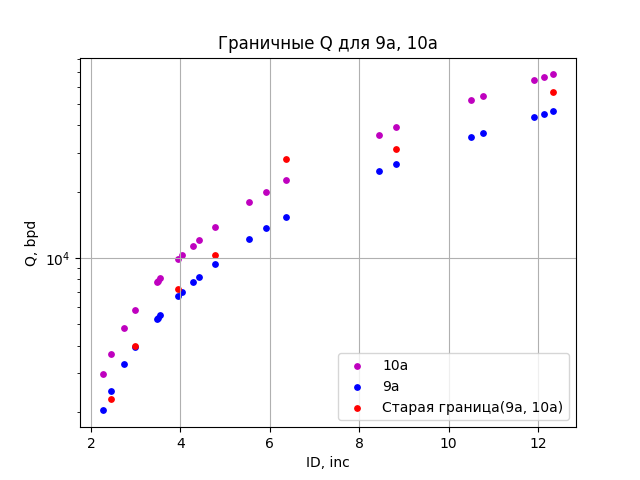

In [103]:
Q_Lite_9, Dinc_9 = recovery_Q(0.5*10**(-8), type=1)
Q_Lite_10, Dinc_10 = recovery_Q(0.5*10**(-7), type=1)

plt.title('Граничные Q для 9a, 10a')
plt.scatter(Dinc_10, Q_Lite_10, color = 'm', s=15)
plt.scatter(Dinc_9, Q_Lite_9, color = 'b', s=15)
plt.scatter(ID_old, Q_old, color = 'red', s=15)
plt.grid()
plt.legend(['10a', '9a', 'Старая граница(9a, 10a)'], loc='lower right')
plt.xlabel('ID, inc')
plt.ylabel('Q, bpd')
plt.yscale('log')

<IPython.core.display.Javascript object>


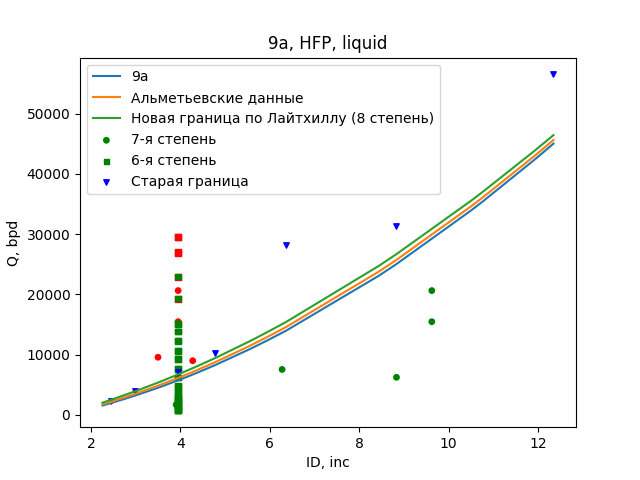

In [151]:
'''
    Функция recovery_Q принимает в аргументы критическую интенсивность по Лайтхиллу (Icr) 
и тип флюида: 1 - water, 2 - oil, 3 - gas.
Возвращает сгенерированный набор значений Q[bpd] и набор внутренних диаметров D[inc]

'''

def recovery_Q_pow(Icr, type, power):
    Din_inc = [2.441, 2.259, 2.992, 2.750, 3.548, 3.476, 3.958, 3.5, 4.408, 4.044, 4.778,
           4.276, 6.366, 5.92, 5.54, 8.835, 8.435, 10.772, 10.5, 12.347, 12.125, 11.907]
    Din_inc.sort()
    Din = np.array(Din_inc)*25.4*10**(-3)
    Dsnl = 40*10**(-3)

    d = (Din-Dsnl)/2

    rho_all=[1000, 780, 150]
    mu_all=[0.4*10**(-3), 10*10**(-3), 0.02*10**(-3)]
    c0_all=[1510, 1290, 430]

    rho=rho_all[type-1]
    mu=mu_all[type-1]
    c0=c0_all[type-1]

    Sin = 3.1416*(Din/2)**2
    Ssnl = 3.1416*(Dsnl/2)**2

    Ucr = (Icr*c0**5/(10**6*rho*d**2))**(1/power)
    Qcr = np.round(Ucr*(Sin-Ssnl)*24*3600/0.16)
    Qcr_m3 = np.round(Ucr*(Sin-Ssnl)*24*3600)
    
    return Qcr, Din_inc

### SNL - 9a
Qcr_8, Din_inc = recovery_Q_pow(0.5*10**(-8), type=1, power=8)
Qcr_7, _ = recovery_Q_pow(0.5*10**(-8), type=1, power=7)
Qcr_6, _ = recovery_Q_pow(0.5*10**(-8), type=1, power=6)

plt.plot(Din_inc, Qcr_8)
plt.plot(Din_inc, Qcr_7)
plt.plot(Din_inc, Qcr_6)

plt.grid()
plt.xlabel('ID, in')
plt.ylabel('Q, bpd')
plt.legend(['degree = 8', 'degree = 7', 'degree = 6'])